In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.auto import tqdm
import timm

In [ ]:
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download dataset
print("\n" + "="*60)
print("Downloading Dataset")
print("="*60)
path = kagglehub.dataset_download("ishans24/brain-tumor-dataset")
print("Path to dataset files:", path)

GPU Available: True
GPU Name: NVIDIA A100-SXM4-40GB
Using device: cuda

Using Colab cache for faster access to the 'brain-tumor-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-dataset


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16  # Reduced for Colab free tier
NUM_EPOCHS = 25
LEARNING_RATE = 3e-4
NUM_WORKERS = 2  # Colab optimized

print("\n" + "="*60)
print("Configuration")
print("="*60)
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")



Configuration
Image Size: 224x224
Batch Size: 16
Epochs: 25
Learning Rate: 0.0003


In [ ]:
class BrainTumorDataset(Dataset):
    """Custom Dataset for Brain Tumor Images"""

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            print(f"Error loading image: {img_path}")
            # Return a black image if loading fails
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def load_dataset(dataset_path):
    """Load and organize dataset"""
    image_paths = []
    labels = []
    class_names = []

    dataset_path = Path(dataset_path)

    print("\nScanning dataset directory...")
    # Find all subdirectories (classes)
    for class_dir in sorted(dataset_path.iterdir()):
        if class_dir.is_dir():
            class_name = class_dir.name
            class_names.append(class_name)
            class_idx = len(class_names) - 1

            # Load all images in this class
            img_count = 0
            for img_file in class_dir.glob('*'):
                if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    image_paths.append(str(img_file))
                    labels.append(class_idx)
                    img_count += 1

            print(f"  {class_name}: {img_count} images")

    print(f"\nFound {len(class_names)} classes: {class_names}")
    print(f"Total images: {len(image_paths)}")

    return image_paths, labels, class_names

In [ ]:
print("\n" + "="*60)
print("Loading Dataset")
print("="*60)
image_paths, labels, class_names = load_dataset(path)
num_classes = len(class_names)



Loading Dataset

Scanning dataset directory...
  glioma: 3754 images
  meningioma: 2343 images
  no_tumor: 1757 images
  pituitary: 2706 images

Found 4 classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Total images: 10560


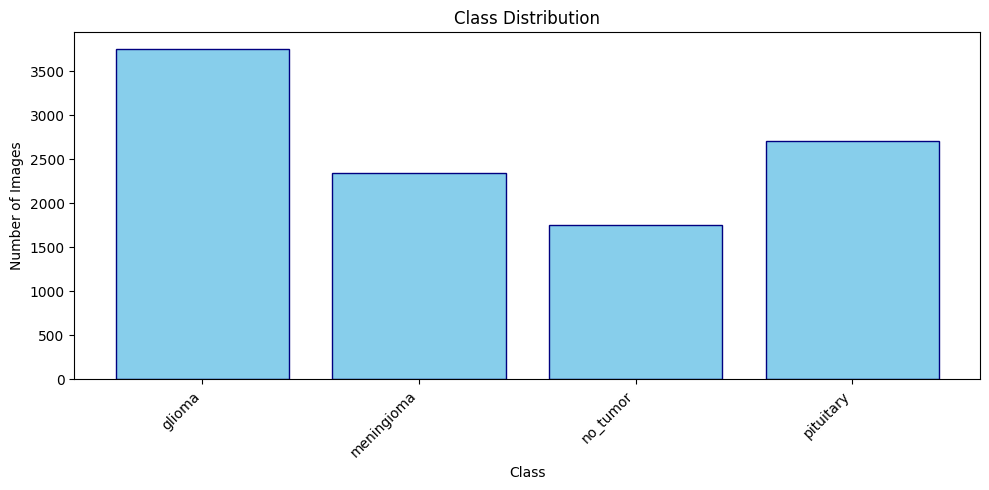


Dataset Split
Training samples: 7392
Validation samples: 1584
Testing samples: 1584


In [ ]:
unique, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar([class_names[i] for i in unique], counts, color='skyblue', edgecolor='navy')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n" + "="*60)
print("Dataset Split")
print("="*60)
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Create datasets
train_dataset = BrainTumorDataset(X_train, y_train, transform=train_transform)
val_dataset = BrainTumorDataset(X_val, y_val, transform=val_test_transform)
test_dataset = BrainTumorDataset(X_test, y_test, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)


Sample Training Images:


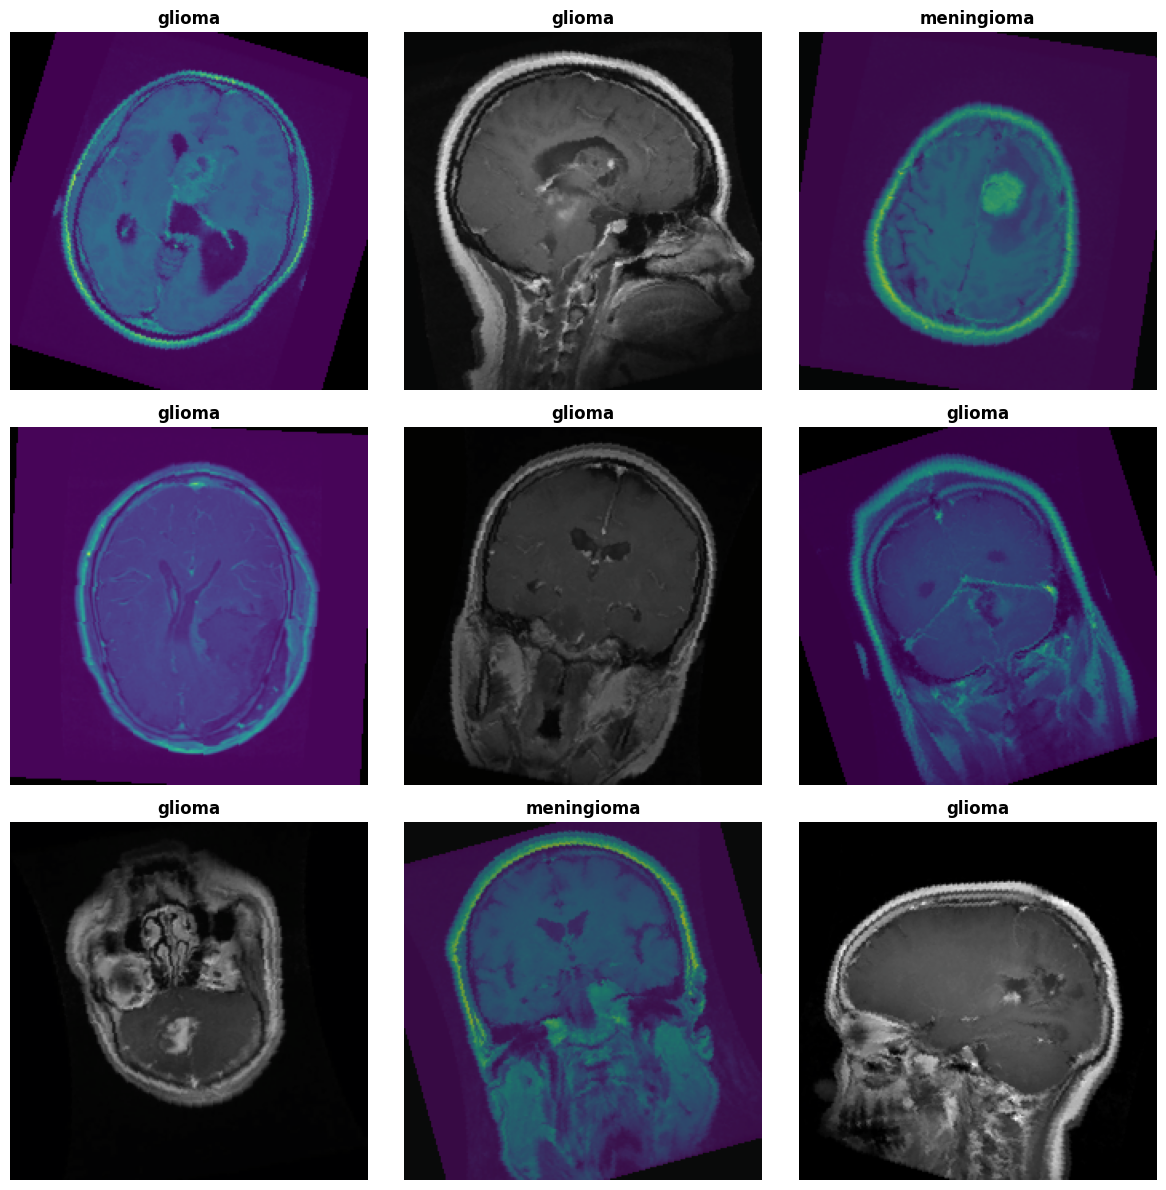

In [ ]:
# Display sample images
def show_sample_images(dataset, class_names, num_samples=9):
    """Display sample images from dataset"""
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        # Denormalize
        image = image.permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].set_title(f'{class_names[label]}', fontsize=12, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\nSample Training Images:")
show_sample_images(train_dataset, class_names)

In [ ]:
class VisionTransformerClassifier(nn.Module):
    """Vision Transformer for Brain Tumor Classification"""

    def __init__(self, num_classes, pretrained=True):
        super(VisionTransformerClassifier, self).__init__()

        # Load pretrained ViT from timm
        print(f"\nLoading Vision Transformer (pretrained={pretrained})...")
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=pretrained)

        # Replace the head with custom classifier
        num_features = self.vit.head.in_features
        self.vit.head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.vit(x)

In [ ]:
# Initialize model
print("\n" + "="*60)
print("Initializing Model")
print("="*60)
model = VisionTransformerClassifier(num_classes=num_classes, pretrained=True).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Number of classes: {num_classes}")


Initializing Model

Loading Vision Transformer (pretrained=True)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Total parameters: 86,194,436
Trainable parameters: 86,194,436
Number of classes: 4


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [ ]:
def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# Training loop
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

print("\n" + "="*60)
print("Starting Training")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Learning rate scheduling
    scheduler.step(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_vit_model.pth')
        print(f"✓ Best model saved! (Val Acc: {val_acc:.2f}%)")

print("\n" + "="*60)
print("Training Completed!")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


Starting Training

Epoch 1/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 1.1205 | Train Acc: 50.51%
Val Loss: 1.0197 | Val Acc: 55.18%
✓ Best model saved! (Val Acc: 55.18%)

Epoch 2/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.8607 | Train Acc: 65.72%
Val Loss: 0.7050 | Val Acc: 71.09%
✓ Best model saved! (Val Acc: 71.09%)

Epoch 3/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.7728 | Train Acc: 68.91%
Val Loss: 0.7927 | Val Acc: 67.68%

Epoch 4/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.7001 | Train Acc: 72.46%
Val Loss: 0.5749 | Val Acc: 79.23%
✓ Best model saved! (Val Acc: 79.23%)

Epoch 5/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.6797 | Train Acc: 73.04%
Val Loss: 0.5905 | Val Acc: 76.83%

Epoch 6/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.6585 | Train Acc: 74.03%
Val Loss: 0.5550 | Val Acc: 79.80%
✓ Best model saved! (Val Acc: 79.80%)

Epoch 7/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.6360 | Train Acc: 74.69%
Val Loss: 0.6442 | Val Acc: 73.93%

Epoch 8/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.6200 | Train Acc: 75.04%
Val Loss: 0.4974 | Val Acc: 81.12%
✓ Best model saved! (Val Acc: 81.12%)

Epoch 9/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.5913 | Train Acc: 76.70%
Val Loss: 0.5304 | Val Acc: 78.09%

Epoch 10/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680><function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.5834 | Train Acc: 76.64%
Val Loss: 0.4907 | Val Acc: 82.70%
✓ Best model saved! (Val Acc: 82.70%)

Epoch 11/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.5907 | Train Acc: 76.87%
Val Loss: 0.4841 | Val Acc: 82.13%

Epoch 12/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.5463 | Train Acc: 78.46%
Val Loss: 0.4485 | Val Acc: 82.83%
✓ Best model saved! (Val Acc: 82.83%)

Epoch 13/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.5430 | Train Acc: 78.34%
Val Loss: 0.4312 | Val Acc: 84.41%
✓ Best model saved! (Val Acc: 84.41%)

Epoch 14/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.5226 | Train Acc: 79.59%
Val Loss: 0.4111 | Val Acc: 84.28%

Epoch 15/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.4891 | Train Acc: 80.90%
Val Loss: 0.4146 | Val Acc: 84.79%
✓ Best model saved! (Val Acc: 84.79%)

Epoch 16/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.7777 | Train Acc: 68.03%
Val Loss: 0.4965 | Val Acc: 79.42%

Epoch 17/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():
     self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive():  
^ ^ ^^ ^ ^ ^ ^ ^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^
   File "/usr/lib/pyth

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.5465 | Train Acc: 78.00%
Val Loss: 0.3886 | Val Acc: 84.85%
✓ Best model saved! (Val Acc: 84.85%)

Epoch 18/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.4855 | Train Acc: 80.78%
Val Loss: 0.4104 | Val Acc: 85.29%
✓ Best model saved! (Val Acc: 85.29%)

Epoch 19/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.4659 | Train Acc: 81.93%
Val Loss: 0.4063 | Val Acc: 83.96%

Epoch 20/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.4461 | Train Acc: 82.47%
Val Loss: 0.4123 | Val Acc: 84.47%

Epoch 21/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.4337 | Train Acc: 83.20%
Val Loss: 0.3900 | Val Acc: 84.91%

Epoch 22/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.4195 | Train Acc: 83.64%
Val Loss: 0.3705 | Val Acc: 85.73%
✓ Best model saved! (Val Acc: 85.73%)

Epoch 23/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb841f74680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.4018 | Train Acc: 84.16%
Val Loss: 0.3520 | Val Acc: 86.93%
✓ Best model saved! (Val Acc: 86.93%)

Epoch 24/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.4012 | Train Acc: 84.73%
Val Loss: 0.4088 | Val Acc: 84.28%

Epoch 25/25
------------------------------------------------------------


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Validation:   0%|          | 0/99 [00:00<?, ?it/s]

Train Loss: 0.3871 | Train Acc: 85.04%
Val Loss: 0.3882 | Val Acc: 85.61%

Training Completed!
Best Validation Accuracy: 86.93%


In [ ]:
# Load best model for testing
checkpoint = torch.load('best_vit_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print("\nBest model loaded for evaluation")


Best model loaded for evaluation


In [ ]:
# Test the model
print("\n" + "="*60)
print("Testing Best Model")
print("="*60)

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())


Testing Best Model


Testing:   0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
# Calculate metrics
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n{'='*60}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"{'='*60}")

print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


Test Accuracy: 86.36%

Detailed Classification Report:
              precision    recall  f1-score   support

      glioma     0.8697    0.8774    0.8736       563
  meningioma     0.7812    0.7102    0.7440       352
    no_tumor     0.9457    0.9278    0.9367       263
   pituitary     0.8676    0.9360    0.9005       406

    accuracy                         0.8636      1584
   macro avg     0.8661    0.8628    0.8637      1584
weighted avg     0.8621    0.8636    0.8622      1584



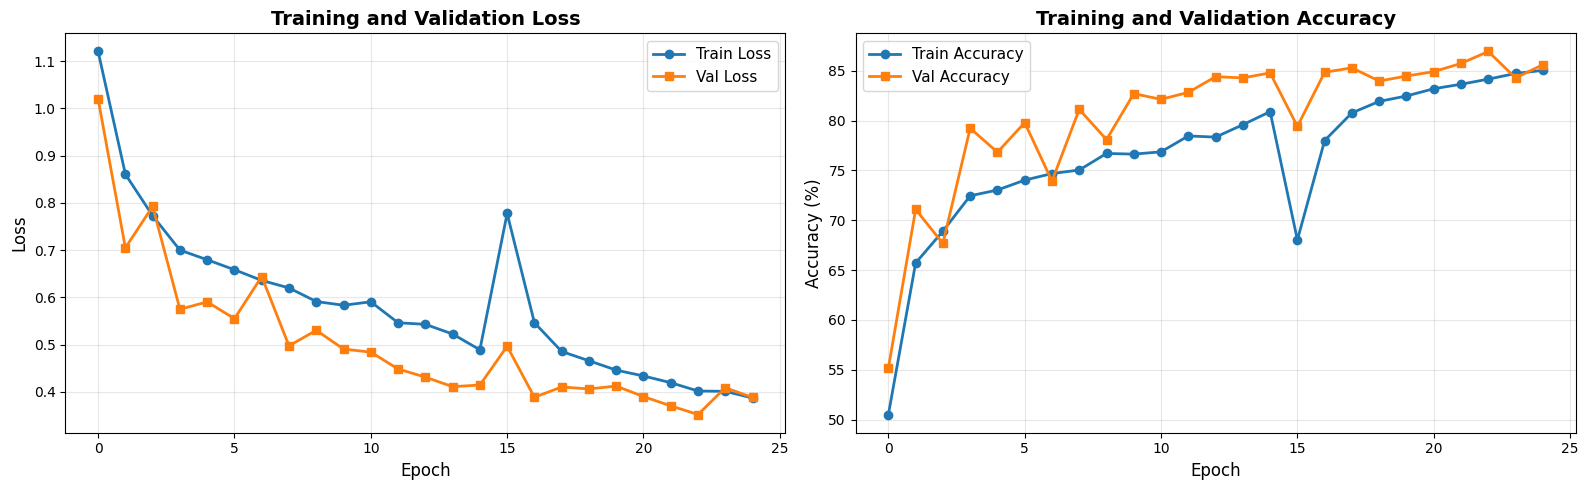

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(train_losses, label='Train Loss', marker='o', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs, label='Train Accuracy', marker='o', linewidth=2)
axes[1].plot(val_accs, label='Val Accuracy', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

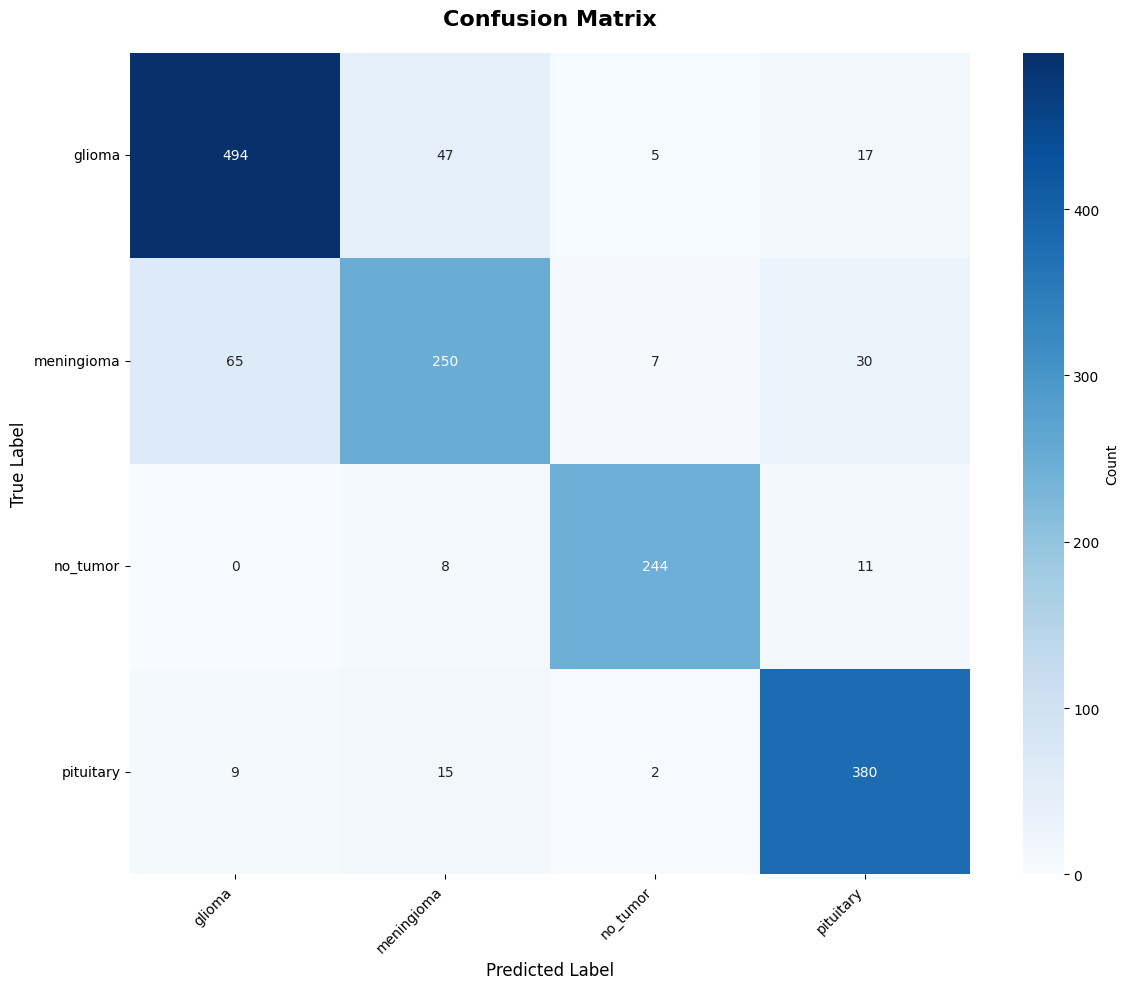

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Per-class accuracy
print("\nPer-Class Accuracy:")
print("-" * 60)
for i, class_name in enumerate(class_names):
    class_mask = np.array(all_labels) == i
    if class_mask.sum() > 0:
        class_acc = (np.array(all_preds)[class_mask] == i).mean() * 100
        print(f"{class_name:20s}: {class_acc:.2f}% ({class_mask.sum()} samples)")

print("\n" + "="*60)
print("All tasks completed successfully!")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Model saved as: best_vit_model.pth")
print(f"Plots saved: training_history.png, confusion_matrix.png")
print("="*60)


Per-Class Accuracy:
------------------------------------------------------------
glioma              : 87.74% (563 samples)
meningioma          : 71.02% (352 samples)
no_tumor            : 92.78% (263 samples)
pituitary           : 93.60% (406 samples)

✓ All tasks completed successfully!
📊 Best Validation Accuracy: 86.93%
📊 Test Accuracy: 86.36%
💾 Model saved as: best_vit_model.pth
📈 Plots saved: training_history.png, confusion_matrix.png
